# Computing EL2N Scores for Dataset Pruning

This notebook implements the Error L2-Norm (EL2N) score calculation as described in the paper ["Deep Learning on a Data Diet: Finding Important Examples Early in Training"](https://arxiv.org/abs/2107.07075) by Paul et al. 

The EL2N score helps identify difficult-to-learn or noisy examples in training datasets. This approach is useful for dataset pruning, where removing certain examples can lead to more efficient training without loss of 

## 1. Model Definition

We define the models we'll use for training and EL2N score computation for both MNIST and CIFAR-10 datasets.

### MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return x

### CIFAR-10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        
        # Modify the first layer to handle CIFAR-10 input size (32x32 with 3 channels)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Remove the original maxpool layer which would reduce the feature map size too much for CIFAR-10
        self.model.maxpool = nn.Identity()
        
        # Adjust the final fully connected layer for 10 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
        
    def forward(self, x):
        return self.model(x)
    
    def extract_features(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

## 2. Data Loading and Preparation

We load the specified dataset and wrap it with a custom dataset class that returns the index along with the data and target. This allows us to track which examples have high or low EL2N scores

In [18]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST
from torchvision import transforms

class DatasetWithIndices(Dataset):
    """
    A wrapper dataset that returns the index along with the data and target.
    """
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]
        return data, target, index

    def __len__(self):
        return len(self.dataset)

def get_dataset(name: str, root: str = './data', with_indices: bool = True, train: bool = True):
    """
    Load and return the specified dataset with optional index wrapping.

    Args:
        name (str): Name of the dataset. One of ['CIFAR10', 'MNIST', 'FashionMNIST']
        root (str): Root directory to store/download the dataset.
        with_indices (bool): If True, return dataset wrapped to include indices.
        train (bool): If True, load the training split; otherwise the test split.

    Returns:
        Dataset: The requested dataset, optionally wrapped to include indices.
    """
    name = name.lower()
    
    if name == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        dataset = CIFAR10(root=root, train=train, download=True, transform=transform)

    elif name == 'digits':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        dataset = MNIST(root=root, train=train, download=True, transform=transform)

    elif name == 'fashion':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        dataset = FashionMNIST(root=root, train=train, download=True, transform=transform)

    else:
        raise ValueError(f"Unsupported dataset: {name}")

    return DatasetWithIndices(dataset) if with_indices else dataset


## 3. Training and EL2N Score Calculation

The EL2N algorithm involves:
1. Training multiple models with different random initializations
2. Computing the L2 norm of the error vector (difference between model predictions and one-hot encoded ground truth) for each example
3. Averaging these L2 norms across all models to get the final EL2N score

We first define helper functions for model training and EL2N score computation.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_model(model, train_loader, epochs=5, lr=0.001):
    """
    Train a model on the given data loader
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target, _) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    
    return model

def compute_el2n_scores(model, data_loader, num_classes=10):
    """
    Compute L2 norm of error vectors for each example
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    l2_norms = {}
    
    with torch.no_grad():
        for data, target, indices in data_loader:
            data, target = data.to(device), target.to(device)
            
            # Get model outputs
            outputs = model(data)
            softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Convert targets to one-hot encoding
            target_one_hot = torch.zeros(target.size(0), num_classes, device=device)
            target_one_hot.scatter_(1, target.unsqueeze(1), 1)
            
            # Calculate L2 norm of error vector for each example
            error_vectors = softmax_outputs - target_one_hot
            batch_l2_norms = torch.norm(error_vectors, p=2, dim=1)
            
            # Store L2 norms with their indices
            for idx, norm in zip(indices.cpu().numpy(), batch_l2_norms.cpu().numpy()):
                if idx in l2_norms:
                    l2_norms[idx].append(norm)
                else:
                    l2_norms[idx] = [norm]
    
    return l2_norms

In [13]:
import torch
from torch.utils.data import DataLoader
import numpy as np

def run_el2n_experiment(
    model_fn,
    train_dataset,
    K=10,
    batch_size=128,
    num_epochs=10,
    learning_rate=0.001,
    compute_el2n_scores_fn=None,
    num_workers=0,
    desc="Network"
):

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    all_l2_norms = {}

    print(f"Training {K} networks with different random initializations...")
    for k in range(K):
        print(f"{desc} {k+1}/{K}")

        model = model_fn()
        model = train_model(model, train_loader, epochs=num_epochs, lr=learning_rate)

        l2_norms = compute_el2n_scores_fn(model, train_loader)

        for idx, norm in l2_norms.items():
            if idx in all_l2_norms:
                all_l2_norms[idx].append(norm)
            else:
                all_l2_norms[idx] = [norm]

    el2n_scores = {idx: np.mean(norms) for idx, norms in all_l2_norms.items()}
    return el2n_scores


In [14]:
torch.manual_seed(42)
digits_train_with_indices = get_dataset('digits', with_indices=True, train=True)

el2n_scores_digits = run_el2n_experiment(
    model_fn=MNISTClassifier,
    train_dataset=digits_train_with_indices,
    K=10,
    batch_size=128,
    num_epochs=10,
    learning_rate=0.001,
    compute_el2n_scores_fn=compute_el2n_scores,
    desc="Digits Network"
)

Training 10 networks with different random initializations...
Digits Network 1/10
Epoch: 1, Batch: 100, Loss: 0.7946
Epoch: 1, Batch: 200, Loss: 0.1972
Epoch: 1, Batch: 300, Loss: 0.1423
Epoch: 1, Batch: 400, Loss: 0.1136
Epoch: 2, Batch: 100, Loss: 0.0858
Epoch: 2, Batch: 200, Loss: 0.0827
Epoch: 2, Batch: 300, Loss: 0.0758
Epoch: 2, Batch: 400, Loss: 0.0670
Epoch: 3, Batch: 100, Loss: 0.0558
Epoch: 3, Batch: 200, Loss: 0.0613
Epoch: 3, Batch: 300, Loss: 0.0550
Epoch: 3, Batch: 400, Loss: 0.0485
Epoch: 4, Batch: 100, Loss: 0.0429
Epoch: 4, Batch: 200, Loss: 0.0506
Epoch: 4, Batch: 300, Loss: 0.0431
Epoch: 4, Batch: 400, Loss: 0.0474
Epoch: 5, Batch: 100, Loss: 0.0399
Epoch: 5, Batch: 200, Loss: 0.0353
Epoch: 5, Batch: 300, Loss: 0.0354
Epoch: 5, Batch: 400, Loss: 0.0368
Epoch: 6, Batch: 100, Loss: 0.0350
Epoch: 6, Batch: 200, Loss: 0.0259
Epoch: 6, Batch: 300, Loss: 0.0303
Epoch: 6, Batch: 400, Loss: 0.0368
Epoch: 7, Batch: 100, Loss: 0.0285
Epoch: 7, Batch: 200, Loss: 0.0272
Epoch: 7

In [ ]:
torch.manual_seed(42)
fashion_train_with_indices = get_dataset('fashion', with_indices=True, train=True)

el2n_scores_fashion = run_el2n_experiment(
    model_fn=MNISTClassifier,
    train_dataset=fashion_train_with_indices,
    K=10,
    batch_size=128,
    num_epochs=10,
    learning_rate=0.001,
    compute_el2n_scores_fn=compute_el2n_scores,
    desc="Digits Network"
)

Training 10 networks with different random initializations...
Digits Network 1/10
Epoch: 1, Batch: 100, Loss: 0.8501
Epoch: 1, Batch: 200, Loss: 0.5064
Epoch: 1, Batch: 300, Loss: 0.4260
Epoch: 1, Batch: 400, Loss: 0.4014
Epoch: 2, Batch: 100, Loss: 0.3475
Epoch: 2, Batch: 200, Loss: 0.3506
Epoch: 2, Batch: 300, Loss: 0.3210
Epoch: 2, Batch: 400, Loss: 0.3127
Epoch: 3, Batch: 100, Loss: 0.2889
Epoch: 3, Batch: 200, Loss: 0.2857
Epoch: 3, Batch: 300, Loss: 0.2887
Epoch: 3, Batch: 400, Loss: 0.2751
Epoch: 4, Batch: 100, Loss: 0.2445
Epoch: 4, Batch: 200, Loss: 0.2485
Epoch: 4, Batch: 300, Loss: 0.2562
Epoch: 4, Batch: 400, Loss: 0.2575
Epoch: 5, Batch: 100, Loss: 0.2267
Epoch: 5, Batch: 200, Loss: 0.2227
Epoch: 5, Batch: 300, Loss: 0.2339
Epoch: 5, Batch: 400, Loss: 0.2329
Epoch: 6, Batch: 100, Loss: 0.2089
Epoch: 6, Batch: 200, Loss: 0.2086
Epoch: 6, Batch: 300, Loss: 0.2059
Epoch: 6, Batch: 400, Loss: 0.2158
Epoch: 7, Batch: 100, Loss: 0.1957
Epoch: 7, Batch: 200, Loss: 0.1859
Epoch: 7

In [ ]:
cifar_train_with_indices = get_dataset('cifar10', with_indices=True, train=True)

el2n_scores_cifar = run_el2n_experiment(
    model_fn=CIFAR10Classifier,
    train_dataset=cifar_train_with_indices,
    K=5,
    batch_size=64,
    num_epochs=5,
    learning_rate=0.001,
    compute_el2n_scores_fn=compute_el2n_scores,
    desc="CIFAR-10 ResNet"
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def save_and_visualize_el2n_scores(el2n_scores, save_path, num_examples=20, title='EL2N Scores'):
    """
    Saves EL2N scores to CSV, visualizes the distribution, and prints top/bottom indices.

    Parameters:
    - el2n_scores (dict): Dictionary of {index: score}.
    - save_path (str): Path to save the CSV file.
    - num_examples (int): Number of top and bottom examples to display.
    - title (str): Title for the histogram plot.
    """
    indices = list(el2n_scores.keys())
    scores = list(el2n_scores.values())

    # Sort by score (descending)
    sorted_pairs = sorted(zip(scores, indices), reverse=True)
    sorted_scores, sorted_indices = zip(*sorted_pairs)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, alpha=0.5)
    plt.title(f'Distribution of {title}')
    plt.xlabel('EL2N Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print top and bottom indices
    print(f"Top {num_examples} indices with highest EL2N scores:")
    print(sorted_indices[:num_examples])

    print(f"\nTop {num_examples} indices with lowest EL2N scores:")
    print(sorted_indices[-num_examples:])

    # Save to CSV
    df = pd.DataFrame({'index': indices, 'el2n_score': scores})
    df.to_csv(save_path, index=False)
    print(f"\nEL2N scores saved to '{save_path}'")


In [ ]:
save_and_visualize_el2n_scores(
    el2n_scores_digits,
    save_path='el2n_scores_digits.csv',
    num_examples=20,
    title='Digits EL2N Scores'
)
save_and_visualize_el2n_scores(
    el2n_scores_fashion,
    save_path='el2n_scores_fashion.csv',
    num_examples=20,
    title='Fashion EL2N Scores'
)   
save_and_visualize_el2n_scores(
    el2n_scores_cifar,
    save_path='el2n_scores_cifar.csv',
    num_examples=20,
    title='CIFAR-10 EL2N Scores'
)

Files already downloaded and verified


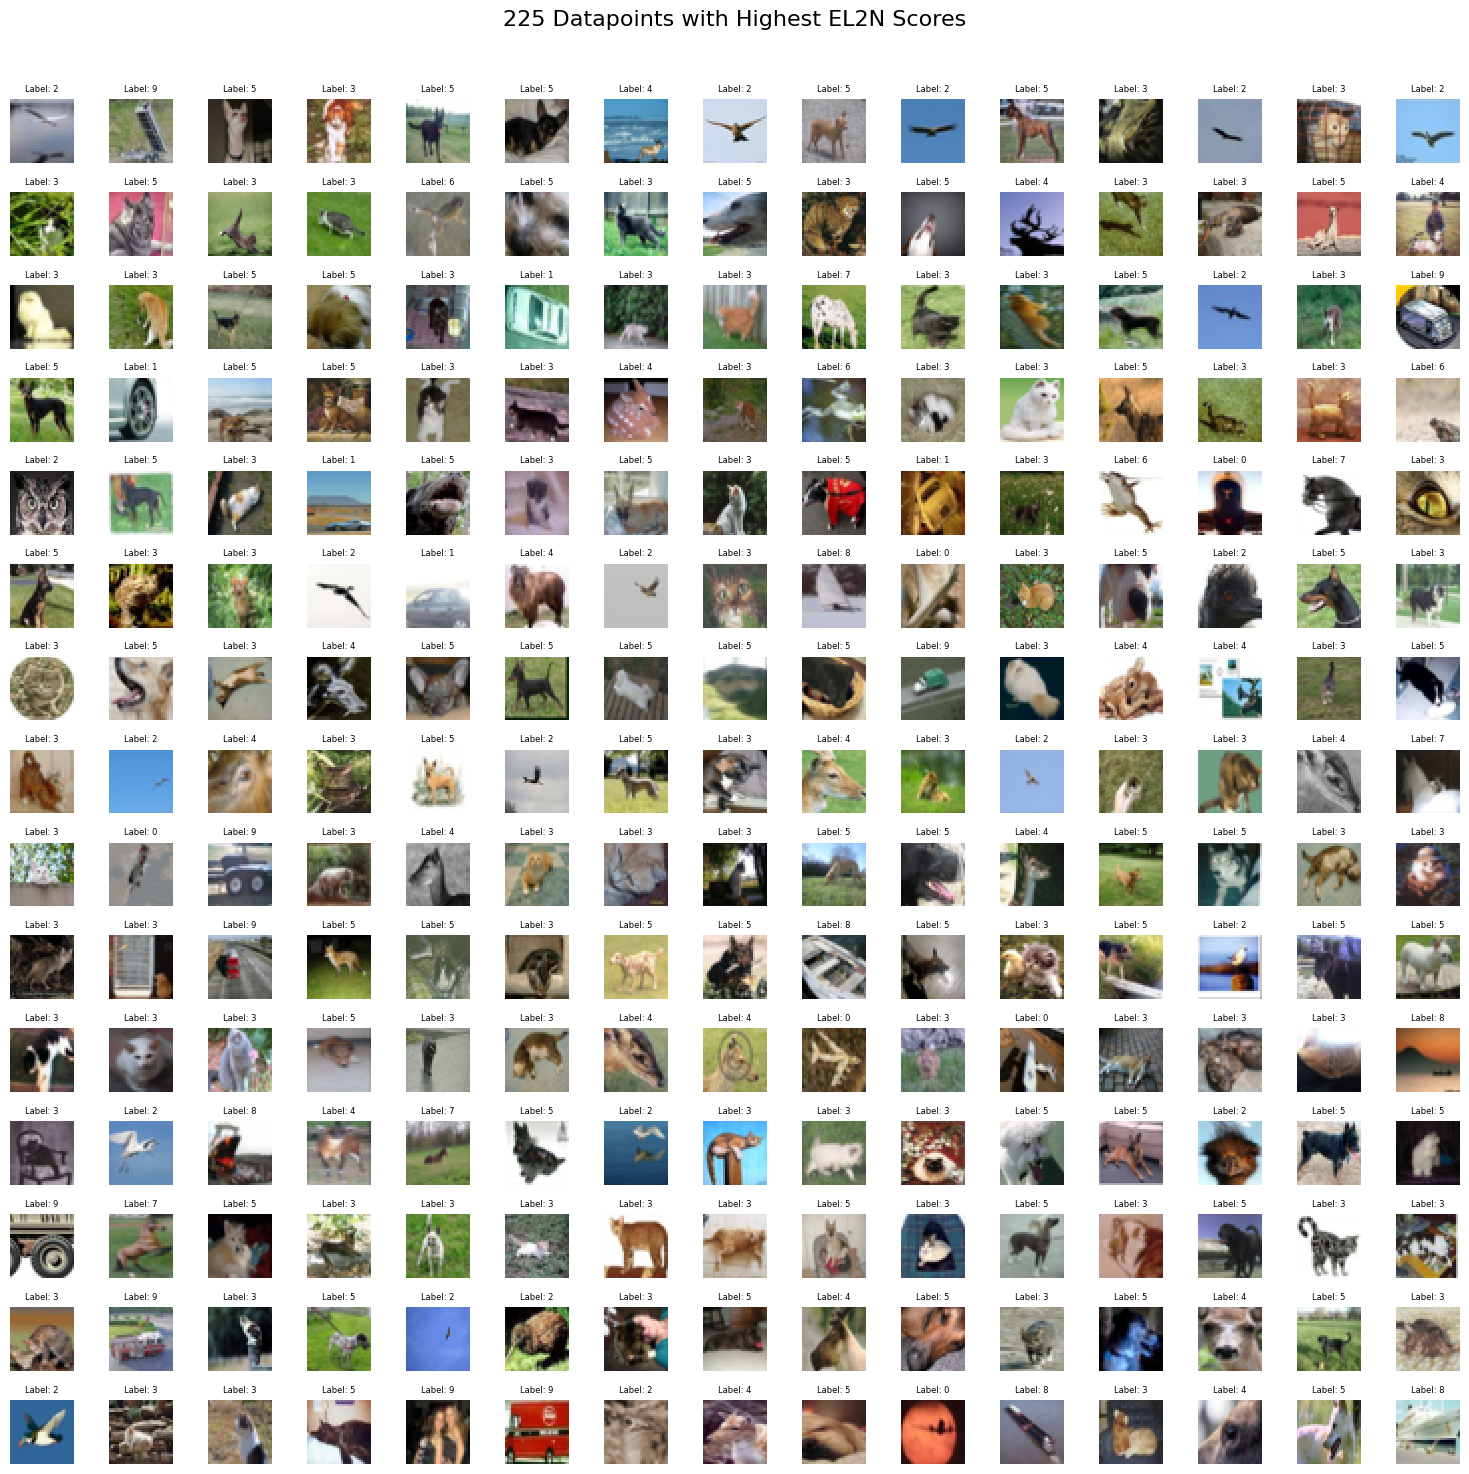

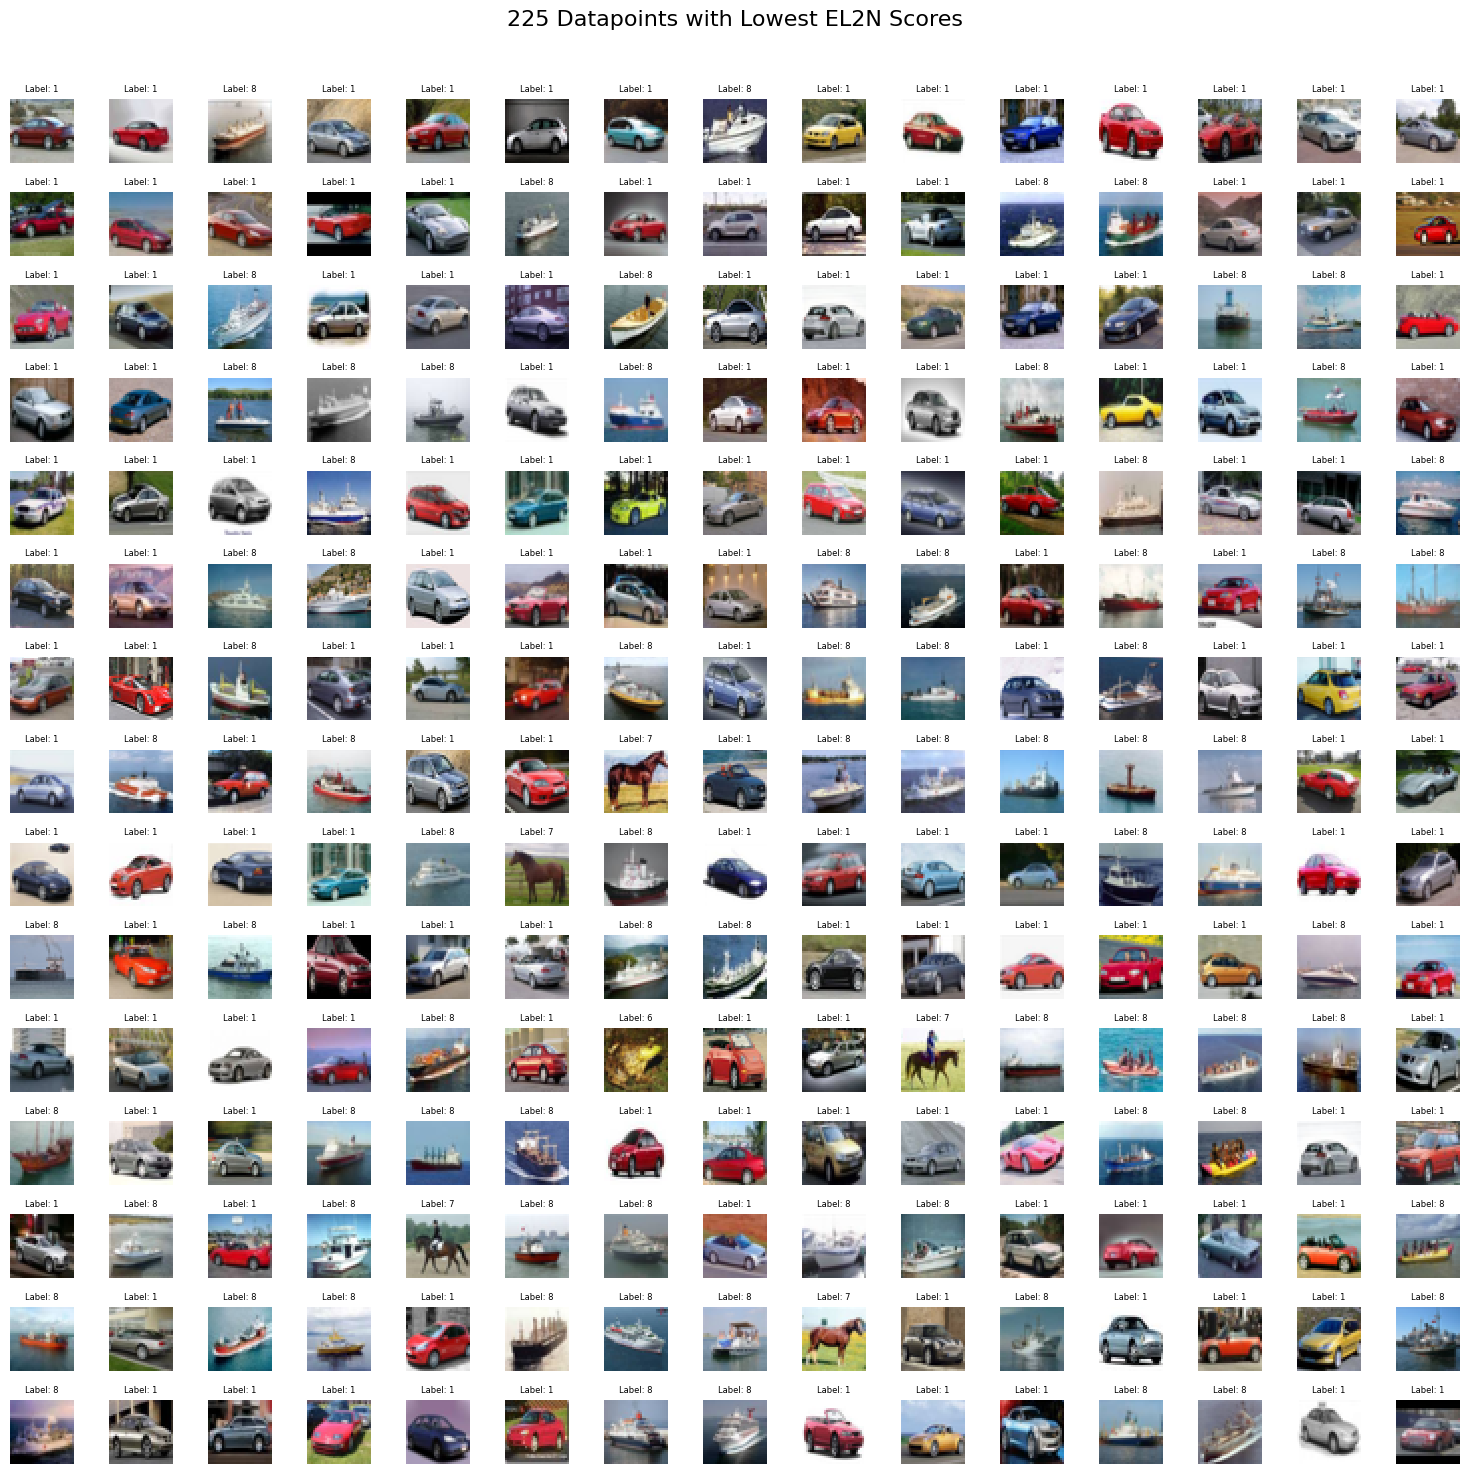

In [20]:
import pandas as pd
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
cifar_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the EL2N scores from the CSV file
el2n_scores_df = pd.read_csv('data/el2n_scores_cifar10_sorted.csv')

# Get the indices of the 225 highest and lowest EL2N scores
top_225_indices = el2n_scores_df.nlargest(225, 'el2n_score')['index'].values
bottom_225_indices = el2n_scores_df.nsmallest(225, 'el2n_score')['index'].values

# Function to denormalize and convert tensor to image
def denormalize_and_convert(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization
    return tensor.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting

# Function to plot images
def plot_images(indices, title, dataset, rows=15, cols=15):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices):
        row, col = divmod(i, cols)
        image, label = dataset[idx]
        axes[row, col].imshow(denormalize_and_convert(image))
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Label: {label}", fontsize=6)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Plot the 225 datapoints with the highest EL2N scores
plot_images(top_225_indices, "225 Datapoints with Highest EL2N Scores", cifar_dataset)

# Plot the 225 datapoints with the lowest EL2N scores
plot_images(bottom_225_indices, "225 Datapoints with Lowest EL2N Scores", cifar_dataset)